### Import standard modules

In [10]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### Import NiPy modules

If you've installed python via miniconda, most packages are available by running `conda install package` in the terminal. In general, if a package is available through conda that's the easiest way to install it. Sometimes packages aren't available through conda, in which case you can use the python package installer, `pip`. If you're running this tutorial on `syzygy.ca`, conda is not installed so all packages are installed through pip. 

In [11]:
#!pip install --user nipy nibabel dipy nilearn nipype

In [12]:
import nipy
import nibabel as nib
import dipy
import nilearn
import nipype

### Load up some sample data

First, we'll load up the MNI T1 template as "t1img". `nib.load()` returns an image object. The exact structure of the image object will depend on what type of file you load. Mostly you're

Read more about nibabel image objects here: http://nipy.org/nibabel/nibabel_images.html

In [13]:
t1img = nib.load('./MNI152_T1_2mm.nii.gz')

In [14]:
type(t1img)

nibabel.nifti1.Nifti1Image

<IPython.core.display.Javascript object>


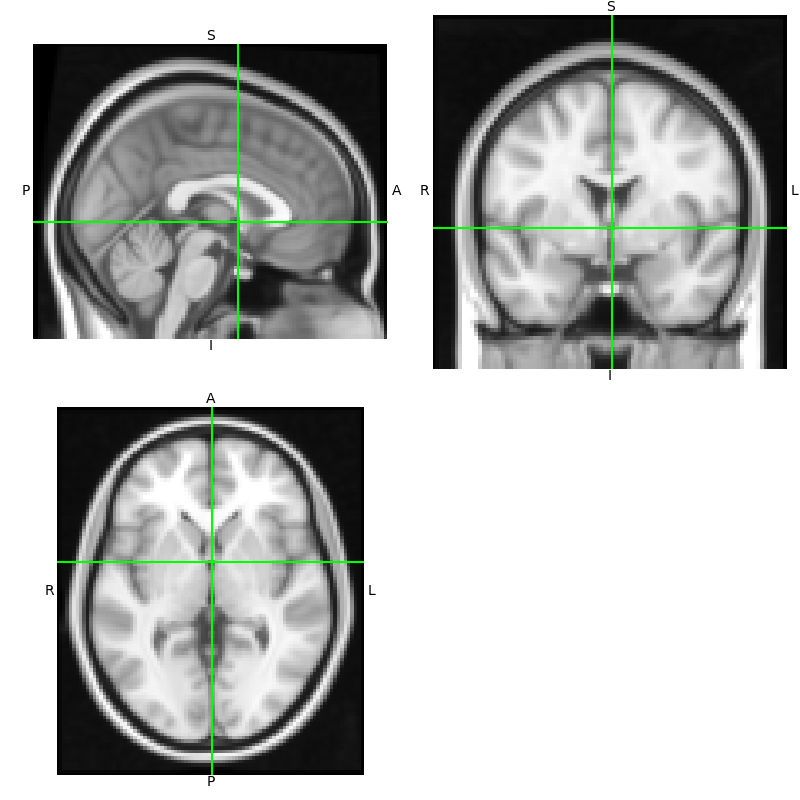

<OrthoSlicer3D: ./MNI152_T1_2mm.nii.gz (91, 109, 91)>

In [15]:
t1img.orthoview()

Loading the image object is fast because it doesn't load the image data automatically. This lets you quickly access header information if that's all you want. To load the image data as a numpy array just call `get_data()`

In [16]:
t1data = t1img.get_data()

In [17]:
type(t1data)

numpy.ndarray

In [18]:
t1data.shape

(91, 109, 91)

In [19]:
t1img.affine

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

### Visualizing a slice is easy

<IPython.core.display.Javascript object>


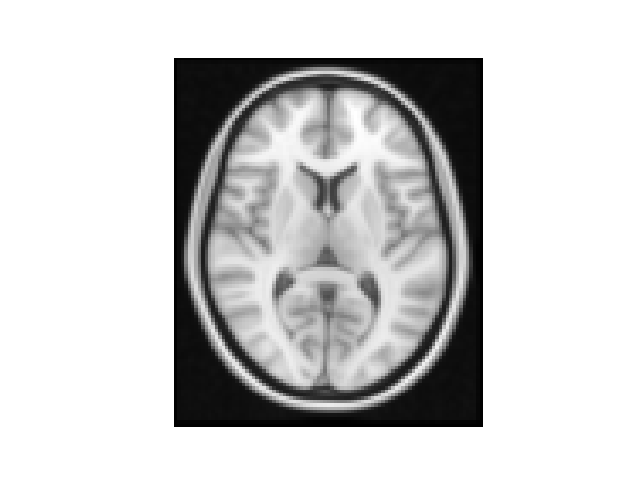

(-0.5, 90.5, 108.5, -0.5)

In [20]:
%matplotlib notebook
f,ax = plt.subplots()
sl=40
t1slice = np.rot90(t1data[:,:,sl])
t1im = ax.matshow(t1slice,cmap='gray')
ax.axis('off')

In [21]:
maskimg = nib.load('./JHU-ICBM-labels-2mm.nii.gz')

In [22]:
maskdata = maskimg.get_data()

In [23]:
maskdata.shape

(91, 109, 91)

<IPython.core.display.Javascript object>


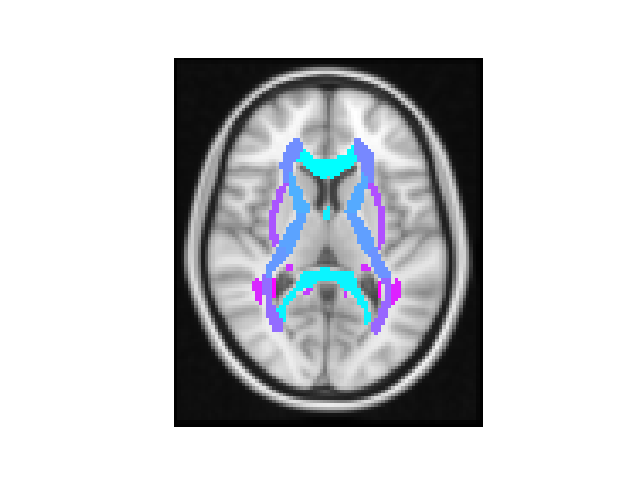

In [24]:
f,ax = plt.subplots()
sl=40
t1slice = np.rot90(t1data[:,:,sl])
t1im = ax.matshow(t1slice,cmap='gray')
ax.axis('off')


maskdata = np.ma.masked_equal(maskdata,0)
maskslice = np.rot90(maskdata[:,:,sl])
maskim = ax.matshow(maskslice,cmap='cool')


### Note: Choose colormaps carefully! 

https://matplotlib.org/users/colormaps.html

### t1data and maskdata are both just numpy 3D arrays, so we perform normal array operations

In [25]:
maskdata.max()

48

In [26]:
maskdata.min()

1

In [27]:
t1data[maskdata==1].mean()

6669.9731296101163

## Exercise (optional): Parse an atlas xml file

* Parse the xml file using xml.etree.ElementTree
* Determine how to access the index and text of each element
* Loop over all the elements and place the data into a dictionary, with the label text as key and the index as value
* Plot an ROI by calling it by it's string, ie 'Body of corpus callosum'
* Evaluate the mean T1 in that ROI, again calling it by name

In [ ]:
import xml.etree.ElementTree

In [ ]:
e = xml.etree.ElementTree.parse('JHU-labels.xml').getroot()

In [ ]:
data = e.find('data')

In [ ]:
labels = data.findall('label')

In [ ]:
label = labels[4]


In [ ]:
label.attrib['index']

In [ ]:
label.text

In [ ]:
labeldict = {}
for label in labels:
    labeldict[label.text] = int(label.attrib['index'])

In [ ]:
labeldict

In [ ]:
f,ax = plt.subplots()
sl=45
t1slice = np.rot90(t1data[:,:,sl])
t1im = ax.matshow(t1slice,cmap='gray')
ax.axis('off')

# Set mask equal to zero except for desired label
maskdata2 = maskdata.copy()
maskdata2[maskdata2 != labeldict['Body of corpus callosum']] = 0
# Make mask a numpy mask so zeros aren't plotted
maskdata2 = np.ma.masked_equal(maskdata2,0)
# select a slice
maskslice = np.rot90(maskdata2[:,:,sl])
# Overlay the mask on the image
maskim = ax.matshow(maskslice,cmap='cool')

## Saving modified images as Nifti files
Let's make a copy of t1data and zero out voxels where maskdata==48

In [ ]:
t1data2 = t1data.copy()

In [ ]:
t1data2[maskdata==48] = 0

### Save the modified image

Create a new nifti image object with `nib.Nifti1Image()`. It needs a image array and an affine matrix

In [ ]:
t1img2 = nib.Nifti1Image(t1data2,t1img.affine)

In [ ]:
t1img2.to_filename('t1img2.nii.gz')

### Nibabel has tools for opening multiple formats including PAR/REC
Loading a PAR/REC image with nibabel and then saving to nifti is, in my experience, more robust than dcm2nii

In [ ]:
nib.parrec?

In [ ]:
nib.load?

## Exercise (optional): Make a  pandas dataframe with the mean values for each ROI
* Calculate the mean of each roi in the JHU atlas. Put in in a list or a dict
* Create a new `pd.DataFrame()` with the list/dict as the data, the mask labels as the index, and a relevant string as the column header 

In [ ]:
means = []
for i in range(maskdata.max()):
    mean = t1data[maskdata==i].mean()
    means.append(mean)

In [ ]:
means;

### Not very "pythonic". Avoid loops when you can do it in one line!

In [ ]:
means = [ t1data[maskdata==i].mean() for i in range(1,maskdata.max()+1)]

In [ ]:
means;

In [ ]:
df = pd.DataFrame(data=means,columns=['Subject 1'],index=range(1,maskdata.max()+1))

In [ ]:
df.head()

In [ ]:
len(df)

Do this for multiple subjects and you've started building a database that you can run stats on, save to Excel, etc.

In [ ]:
pd.DataFrame?

## Manipulating the affine
The affine matrix describes the relationship between the image matrix and the "real world" coordinate system. Image orientation manipulation should be approached with caution, but it's often necessary.

In [ ]:
t1img.shape

In [ ]:
t1img.header.get_zooms()

In [ ]:
t1img.affine

In [ ]:
canonical_t1img = nib.as_closest_canonical(t1img)
canonical_t1img.affine

In [ ]:
canonical_t1img.shape

In [ ]:
t1img.shape

In [ ]:
canonical_t1data = canonical_t1img.get_data()

In [ ]:
f,ax = plt.subplots(1,2)
sl=45
t1im = ax[0].matshow(np.rot90(t1data[:,:,sl]),cmap='gray')
t1im_canon = ax[1].matshow(np.rot90(canonical_t1data[:,:,sl]),cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
t1img.orthoview()
canonical_t1img.orthoview()


## Notice the difference?

Hard to spot, but the canonical oriented image is flipped left/right from the standard image. If you have a sagitally acquired image, the image will be reoriented in more dimensions.

## Exercise: Rotate the image and the affine matrix by 90 degrees. Save and open in FSL. Are the orientation labels correct?

http://nipy.org/nibabel/coordinate_systems.html

In [28]:
t1imrot = np.rot90(t1data,k=2,axes=(1,2))

### First, let's look at the image with the rotated data and original affine

In [29]:
t1imrot_nii = nib.Nifti1Image(t1imrot,t1img.affine)

<IPython.core.display.Javascript object>


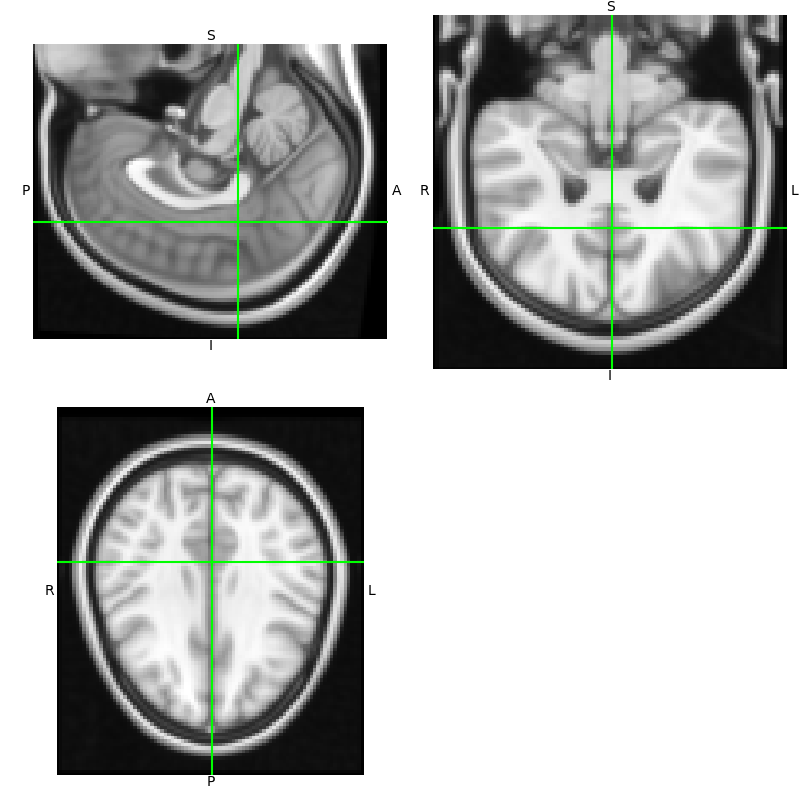

<OrthoSlicer3D: (91, 109, 91)>

In [30]:
t1imrot_nii.orthoview()

### Now, let's add the new affine

In [31]:
cos_gamma = np.cos(np.pi)
sin_gamma = np.sin(np.pi)

In [68]:
rotation_affine = np.array([[1, 0, 0, 0],
                                [0, cos_gamma, -sin_gamma, 0],
                                [0, sin_gamma, cos_gamma, 0],
                                [0, 0, 0, 1]])

In [69]:
outaff = t1img.affine.dot(rotation_affine)

In [70]:
print(outaff)

[[ -2.00000000e+00   0.00000000e+00   0.00000000e+00   9.00000000e+01]
 [  0.00000000e+00  -2.00000000e+00  -2.44929360e-16  -1.26000000e+02]
 [  0.00000000e+00   2.44929360e-16  -2.00000000e+00  -7.20000000e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [71]:
t1img.affine

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [72]:
t1imrot_nii = nib.Nifti1Image(t1imrot,outaff)

<IPython.core.display.Javascript object>


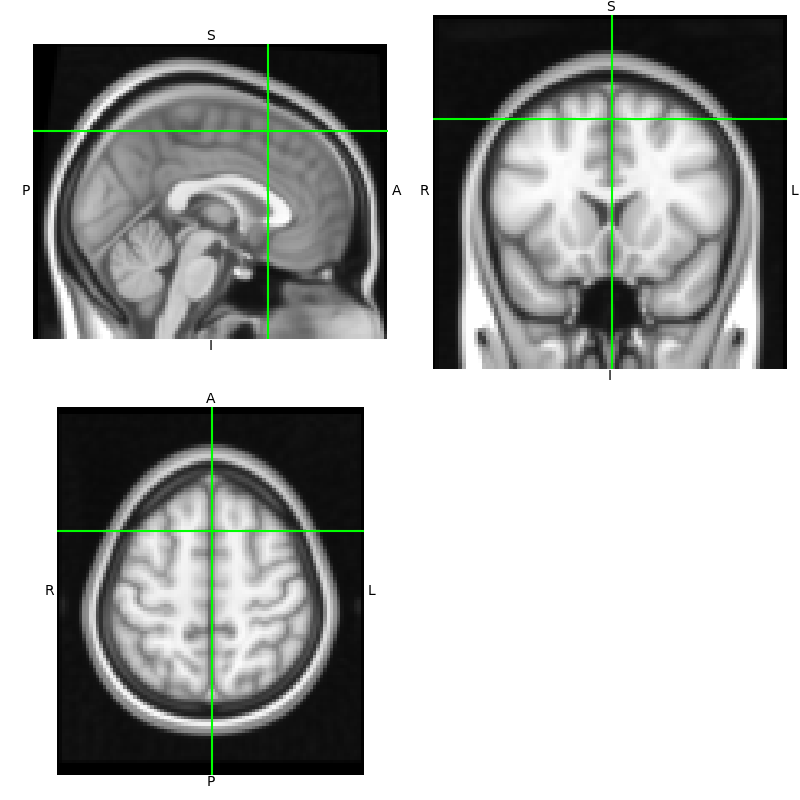

In [73]:
ortho = t1imrot_nii.orthoview()

In [53]:
ortho.position

array([ 0.,  0.,  0.])

In [82]:
ortho.set_position(0,-200,-125)

The coordinates are weird now, but the image is oriented correctly. We actually need to add a translation to the rotation to get our indexes back to zero.

## Example: Tissue segmentation

http://nipy.org/dipy/examples_built/tissue_classification.html#example-tissue-classification

Let's run a tissue classification algorithm on our T1 image

In [ ]:
from dipy.data import fetch_tissue_data, read_tissue_data
from dipy.segment.tissue import TissueClassifierHMRF

In [ ]:
# Number of tissue classes
nclass = 3

In [ ]:
# Smoothing factor. Good values 0-0.5
beta = 0.1

In [ ]:
# Markov Random Field classifier. Similar algorithm to FAST and ANTS
hmrf = TissueClassifierHMRF()

In [ ]:
initial_segmentation, final_segmentation, PVE = hmrf.classify(t1data, nclass, beta)

In [ ]:
final_segmentation.max()

In [ ]:
final_segmentation.min()

In [ ]:
f,axs = plt.subplots(1,3)
axs[0].matshow(np.rot90(final_segmentation[:,:,40]))
axs[1].matshow(np.rot90(final_segmentation[:,50,:]))
axs[2].matshow(np.rot90(final_segmentation[40,:,:]))

[ax.set_axis_off() for ax in axs]

In [ ]:
PVE.shape

In [ ]:
f,axs = plt.subplots(1,3)
axs[0].matshow(np.rot90(PVE[:,:,40,1]))
axs[1].matshow(np.rot90(PVE[:,50,:,1]))
axs[2].matshow(np.rot90(PVE[40,:,:,1]))

[ax.set_axis_off() for ax in axs]

## Nipype: Integrate imaging software into your Python code

https://miykael.github.io/nipype_tutorial/

Nipype is an amazing utility that allows you to link together different non-Python imaging tools within your Python analysis. It can be used simply to (for example) add FSL's eddy correction processing to you Python DTI processing; or it can be used to organize your entire processing workflow.

Personally I don't use the full workflow functionality. Instead I use it to call FSL and SPM functions from my Python scripts. It's much easier to write everything in pure Python instead of switching back and forth between FSL command line tools and SPM in Matlab. Nipype has an amazing number of interfaces, including:
* FSL
* SPM
* FreeSurfer
* niftireg
* ANTS
* AFNI
* Camino
* MIPAV
* DTK

Full list here: http://nipype.readthedocs.io/en/latest/documentation.html

For the Nipype interfaces to work, you just have to have the software you want to use install and certain environmental variables set so that Python knows where to look for the programs. For example,

In [ ]:
!echo $FSLDIR

None of these software tools are on the syzygy server. This example will only work on a computer with FSL installed.

In [ ]:
import nipype.interfaces.fsl as fsl

In [ ]:
flt = fsl.FLIRT()

In [ ]:
flt.inputs.in_file = 'MNI152_T1_2mm.nii.gz'
flt.inputs.reference = 'MNI152_T1_1mm.nii.gz'
flt.inputs.out_file = 'MNI_T1_2mm_to_1mm.nii.gz'

In [ ]:
results = flt.run()

In [ ]:
results.

In [ ]:
my_reg_file = results.outputs.out_file

`my_reg_file` is a string describing a path to a file. We can now use this variable as the input to another nipype interface, or we can load the nifti file into Python with the tools we learned previously.

## Exercise: DTI processing
http://nipy.org/dipy/examples_built/reconst_dti.html#example-reconst-dti

In [ ]:
import dipy.reconst.dti as dti
from dipy.data import read_stanford_hardi

In [ ]:
img, gtab = read_stanford_hardi()

In [ ]:
img

In [ ]:
gtab

The gtab (**g**radient **tab**le) is the object that holds the gradient information. This example gives it to us automatically. If you created your dti nifti file with dcm2nii, it probably also gave you  .bvec and .bval files. In that case, you could create the gtab with
```
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)
```

If you're reading data straight from a PAR/REC file, 
```
dtipar = nib.parrec.load(dti_par)
bvals, bvecs = dtipar.header.get_bvals_bvecs()
gtab = gradient_table(bvals, bvecs)
```

In [ ]:
data = img.get_data()
print('data shape: {}'.format(data.shape))

In [ ]:
f,axs = plt.subplots(2,2)
for ax, vol in zip(axs.flatten(),range(0,160,40)):
    ax.matshow(np.rot90(data[:,:,25,vol]))
    ax.set_axis_off()
f.subplots_adjust(hspace=.05, wspace=0)

In [ ]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, 3, 1, False, vol_idx=range(10, 50), dilate=2)
print('maskdata.shape {}' .format(maskdata.shape))

In [ ]:
mask.shape

In [ ]:
f,(ax1,ax2,ax3) = plt.subplots(1,3)
ax1.matshow(np.rot90(data[:,:,40,0]))
ax2.matshow(np.rot90(maskdata[:,:,40,0]))
ax3.matshow(np.rot90(mask[:,:,40]))
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

Create a TensorModel object with our gradient information

In [ ]:
tenmodel = dti.TensorModel(gtab)

In [ ]:
# This will take at least a minute, be patient
tenfit = tenmodel.fit(maskdata,mask=mask)

In [ ]:
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular

FA = fractional_anisotropy(tenfit.evals)

In [ ]:
plt.matshow(np.rot90(FA[:,:,40]))
plt.gca().set_axis_off()

That's it! We can save the FA as a nifti, or do some numerical analysis on it with numpy, or make publication images, or whatever. 

## Exercise: Add an eddy correction step to the above pipeline using a Nipype interface

## Exercise: fMRI analysis with ICA

http://nilearn.github.io/connectivity/resting_state_networks.html

In [ ]:
# Get some sample data. This data sample is already pre-processed -- normally you need to motion correct, etc.

from nilearn import datasets

adhd_dataset = datasets.fetch_adhd(n_subjects=4)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

In [ ]:
func_filenames

In [ ]:
from nilearn.decomposition import CanICA

In [ ]:
CanICA?

In [ ]:
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)

In [ ]:
# This will take about a minute
canica.fit(func_filenames)

In [ ]:
# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)

In [ ]:
components_img.

In [ ]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components',anat_img='MNI152_T1_2mm.nii.gz')

In [ ]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)